In [42]:
import os
import re
import pprint
from unicodedata import name as uname

from IPython.display import display, HTML, Image

import fitz

PP = pprint.PrettyPrinter(indent=4)

In [107]:
NAME = "Lakhnawi"
SOURCE = f"../_local/source/{NAME}/{NAME.lower()}.pdf"
PNG = f"../_local/source/{NAME}/{{}}.png"

In [10]:
PRIVATE_RE = re.compile(r"""[\ue000-\uf8ff]""")

def postText(data):
    print(PRIVATE_RE.sub("", data))

In [11]:
ENTITY_RE = re.compile(r"""&#x([0-9a-f]{1,4});""", re.S)

PUA_LOW = int("e000", base=16)
PUA_HIGH = int("f8ff", base=16)


def entityRepl(match):
    code = match.group(1)
    unicode = int(code, base=16)
    return f"[{code}]" if PUA_LOW <= unicode <= PUA_HIGH else chr(unicode)
    

PRIVATE_ENTITY_RE = re.compile(
    r"""
    &\#x
    (?:
        (?:
            e
            [0-9a-f]{3}
        )
        |
        (?:
            f
            [0-8]
            [0-9a-f]{2}
        )
    )
    ;
    """,
    re.S | re.X,
)

In [93]:
LINES_RE = re.compile(r"""<line\b[^>]*>(.*?)</line>""", re.S)
CHARS_RE = re.compile(r"""<char\b[^>]*>(.*?)/>""", re.S)
CHAR_RE = re.compile(r'''\bc="([^"]*)"''', re.S)


CSS = """
<style>
.ar {
    font-family: normal, sans-serif;
    font-size: 30pt;
}
"""

display(HTML(CSS))

In [4]:
doc = fitz.open(SOURCE)

In [97]:
def postRAWDICT(data):
    data = data["blocks"][0]["lines"][0:3]
    PP.pprint(data)

In [117]:
def postRAWDICT(data):
    result = []
    collectChars(data, "", result)
    result = sortChars(result)
    rows = []
    rows.append("<table>")
    for r in result[0:100]:
        ch = r[5]
        nu = ord(ch)
        if PUA_LOW <= nu <= PUA_HIGH:
            ch = "█"
            ru = f"????"
            priv = "*"
        else:
            ru = uname(ch)
            priv = ""
        rows.append(
            f"""\
<tr>
    <td>{r[1]:>6.2f}</td>
    <td>{r[3]:>6.2f}</td>
    <td>{r[2]:>6.2f}</td>
    <td>{r[0]:>6.2f}</td>
    <td>{r[4]:<30}</td>
    <td>{priv:>1}{nu:04x}</td>
    <td class="ar">{ch:>1}</td>
    <td>{ru}</td>
</tr>
"""
        )
    rows.append("</table>")
    # PP.pprint(rows)
    display(HTML("".join(rows)))
    return


def collectChars(data, font, resultChars):
    if type(data) is list:
        for elem in data:
            collectChars(elem, font, resultChars)
    elif type(data) is dict:
        if "font" in data:
            font = data["font"]
        if "c" in data:
            resultChars.append((*data["bbox"], font, data["c"]))
        for (k, v) in data.items():
            if type(v) in {list, dict}:
                collectChars(v, font, resultChars)


def sortChars(chars):
    return sorted(chars, key=lambda c: (c[3], -c[2]))

In [116]:
"""١۱٠۰١۱"""

'١۱٠۰١۱'

In [118]:
process(doc[100], "RAWDICT")

In [76]:
def postDICT(data):
    data = data["blocks"][0]["lines"][0:3]
    PP.pprint(data)

In [77]:
def postBLOCKS(data):
    data = data[0:10]
    PP.pprint(data)

In [78]:
def makeText(words):
    """
    Credits to Jorj X. McKie (https://github.com/JorjMcKie)
    See https://github.com/pymupdf/PyMuPDF/issues/702
    """
    lineDict = {}  # key: vertical coordinate, value: list of words
    words.sort(key=lambda w: w[0])  # sort by horizontal coordinate
    for w in words:  # fill the line dictionary
        y1 = round(w[3], 0)  # bottom of a word: don't be too picky!
        word = w[4]  # the text of the word
        line = lineDict.setdefault(y1, [])  # read current line content
        line.append(word)  # append new word
    lines = sorted(lineDict.items())
    return "\n".join([" ".join(line[1]) for line in lines])

In [79]:
def postWORDS(data):
    text = makeText(data)
    text = PRIVATE_RE.sub("", text)
    print(text)

In [80]:
def postWORDS(data):
    data = data[0:10]
    PP.pprint(data)

In [81]:
def postXML(material):
    data = []
    
    lineMaterials = LINES_RE.findall(material)
    
    for lineMaterial in lineMaterials:
        line = []
        
        charMaterials = CHARS_RE.findall(lineMaterial)
        
        for charMaterial in charMaterials:
            match = CHAR_RE.search(charMaterial)
            if not match:
                continue
            char = match.group(1)
            char = ENTITY_RE.sub(entityRepl, char)
            if len(char) == 1:
                char = f"""<span class="ar">{char}</span>"""
            line.append(char)
            
        data.append("".join(line))
    
    text = "\n<hr>\n".join(data)
    
    display(HTML(text))

In [82]:
def postHTML(data):
    print("WITH PRIVATE CHARS")
    print(data[0:1000])
    data = PRIVATE_ENTITY_RE.sub("", data)
    print("WITHOUT PRIVATE CHARS")
    print(data[0:1000])
    display(HTML(data))

In [114]:
def process(page, method):
    """
    Text WORDS BLOCKS DICT RAWDICT HTML
    """
    textPage = page.getTextPage()
    
    if method == "PNG":
        pix = page.getPixmap(matrix=fitz.Matrix(4, 4), alpha = False)
        display(Image(data=pix.getPNGData(), format="png"))
        # pix.writePNG(PNG.format(page.number))
        return
    
    extractMethod = getattr(textPage, f"extract{method}", None)
    if extractMethod:
        data = extractMethod()
    else:
        return
    
    processMethod = globals().get(f"post{method}", None)
    if processMethod:
        processMethod(data)
    else:
        PP.pprint(data)

In [33]:
process(doc[100], "WORDS")

١۱٠۰١۱
،مﻡﻮﱠﻓَﹶﻘْﹾﺪَﹶ ﻦﻧﻲﻓاﺍﻲﻨﻟ  :لﻝﺎَﹶﻣآﺁرﺭ » ―ﻗ مﻡَﹶ  ﻪﺴﻟ اﺍ،هﻩَﹶﺪْﹾﻧﻪﱠ―ﻋﻠَﹶﻴاﺍ  ﺖﻋﻨ اﺍﻟيﻱِﹺﺬﱠﺛَﹶﺒ
هﻩآﺁﺮَﹶﺑﻘﻲﺑﻦ 171ﻓ ،«ﻲ رﺭﻮﺗ َﹶنﻥﺎَﹶﻳﺘَﹶﻤـﺜﻞﱠﻋﻠﲐﺻ َﹶ ﱠﻴﻄ  ﻘﻈ،ﺔَﹶﻓاﺍﱠنﻥﺎَﹶﺸﻟ آﺁرﺭﻧﻲﻓاﺍﻲﻴﻟ
قﻕﱠﺪﺑﻘﻲ هﻩِﹺﺬﻟؤﺅﺮﻳﺎﻟـَﹶﺒﻨ،ﺎًﹰﻓَﹶﺼ ﻪﺳﻠﻢﱠﻓﻲﻫاﺍ وﻭ ﻪﻋﻠَﹶﻴ ﻠاﺍﲐﱠ ﻟ ﱠﺒﻲِﹺﺻ وﻭ،ٍﹴﺪَﹶﺳﻘاﺍ هﻩﺎَﹶﻨﻟ ﻣﺨـﻠ
ﻞﻋﻦ١۱٣۳٠۰٠۰ ﺎﺑﻻﺔﻘﻳ  ﻮﻳﺬﻛﺮﻋاﺍدﺩﺪﻣاﺍﻦﺤﺼﻟ   .ﺔﻬﻓ ) اﺍﺪﻳ اﺍﺔﺒﻟ  ،ﺪﻫﻢﻄﻘﻧ   ﻹاﺍﺪﻣأﺃمﻡﺎﻤﺣ   ﻨﺴﻣ 
ﺮ  ﺎﻴﺜﻳ   ﺲﻤﻣ وﻭ.ﺔﻴﻟ  ﻷاﺍﺐﺑاﺍبﺏاﺍﻮﻴﻬﻘﻔﻟ     ٍﹴوﻭاﺍرﺭﻞﺗﺮﺗﺐﺴﺤﺑ  أﺃنﻥأﺃﺮﺣدﺩﺎﻳﺚﻛ  ،(ﺎﻴﻏ ﺎﻴﺑ   ﺤﺻ
ﻲ اﺍنﻥاﺍﺪﺘﻟ  اﺍﰲﲐﻠﺒﻟ   ﺔﺘﺣ  اﺍﺐﺘﺴﻟ   اﺍﻪﺘﻜﻟ   ﺖﻠﺤﻣ   اﺍﻮﻣﻊﻗﺪﻠﺣ  عﻉﻮﻣاﺍﻦﺠﻟ نﻥأﺃﺔﻫاﺍاﺍﺬﻨﻟ  اﺍﻟﺪﺸﻫ
ﻪ ﺆﻔﻟ ﻦﻤﻟ  وﻭ:ﺪﻫأﺃﻮﻧﻪﻟﻢﻜﺗ  ﻲﺑﻦﻠﺨﻣ ﺪﻘﺑ قﻕﺎﻣﻨﺴ  إﺇىﻯﺰﻴﻟإﺇﻪﻔﺧ آﺁﺐﺧﺮﻌﻳ ﺔﺒﺳ وﻭ.ﺎﻤﺛ  ﺄﻬﻴﻓ  ﺸﻧ
ﻪ  وﻭ.هﻩﺮﻛيﻱﺄﻴﻘﻓ  ﰲﺔﺼﻋ  ﺎﺋاﺍﻞﻴﻬﻘﻔﻟ    ﻞﻣاﺍﻦﺴﻤﻟ   اﺍﻪﻘﺘﺴﻤﻟ   ﺐﻣﻮﻔﻗ  ﺔﺑأﺃﲔﻗاﺍﺮﻧ،ﻪﺒﺴﺑ ﺔﺒﻴﻃ  ﻌﻤﺳ 
ﺪﻗسﺱِﹺرﺭدﺩﺪﺧلﻝﻼﻓةﺓﱰ  ﻲﺑﻦﻠﺨﻣ ﺪﺑﻘﺒ  وﻭ.ءﺀﺎﺒﻳنﻥأﺃوﻭﺪﻨﺴﻣ  اﺍﺮﻣزﺯﻦﻣاﺍةﺓﺮﻬﻘﻔﻟ   ﻞﻋﺎﻧﲐﻴﺜﻛ  ﻘﺘﺴﻣ 
ﺔﻴﻨﻣزﺯ٣۳١۱٣۳.«ﻪﻟ اﺍﺮﺼﺘﺨﻣ (ـﻫ تﺕ) ﻊﻴﻓرﺭ ﻲﺧأﺃ ﻦﺑاﺍ ﺐﺘﻛ ﺚﻴﺣ ،ةﺓﺮﻴﺼﻗ
َﹶنﻥﺎَﹶﻳﺘَﹶﻤـﺜﻞﱠﻋﻠﲐ َﹶ ﱠﻴﻄ  ﻘﻈ،ﺔَﹶﻓاﺍﱠنﻥﺎَﹶﺸﻟ ،مﻡﻮﱠﻓَﹶﻘآﺁرﺭْﹾﺪَﹶﻧﻲﻓاﺍﻲﻴﻟ ﻦﻧﻲﻓاﺍﻲﻨﻟ  171.»ﻣآﺁرﺭ
،ﺮﺑبﺏ

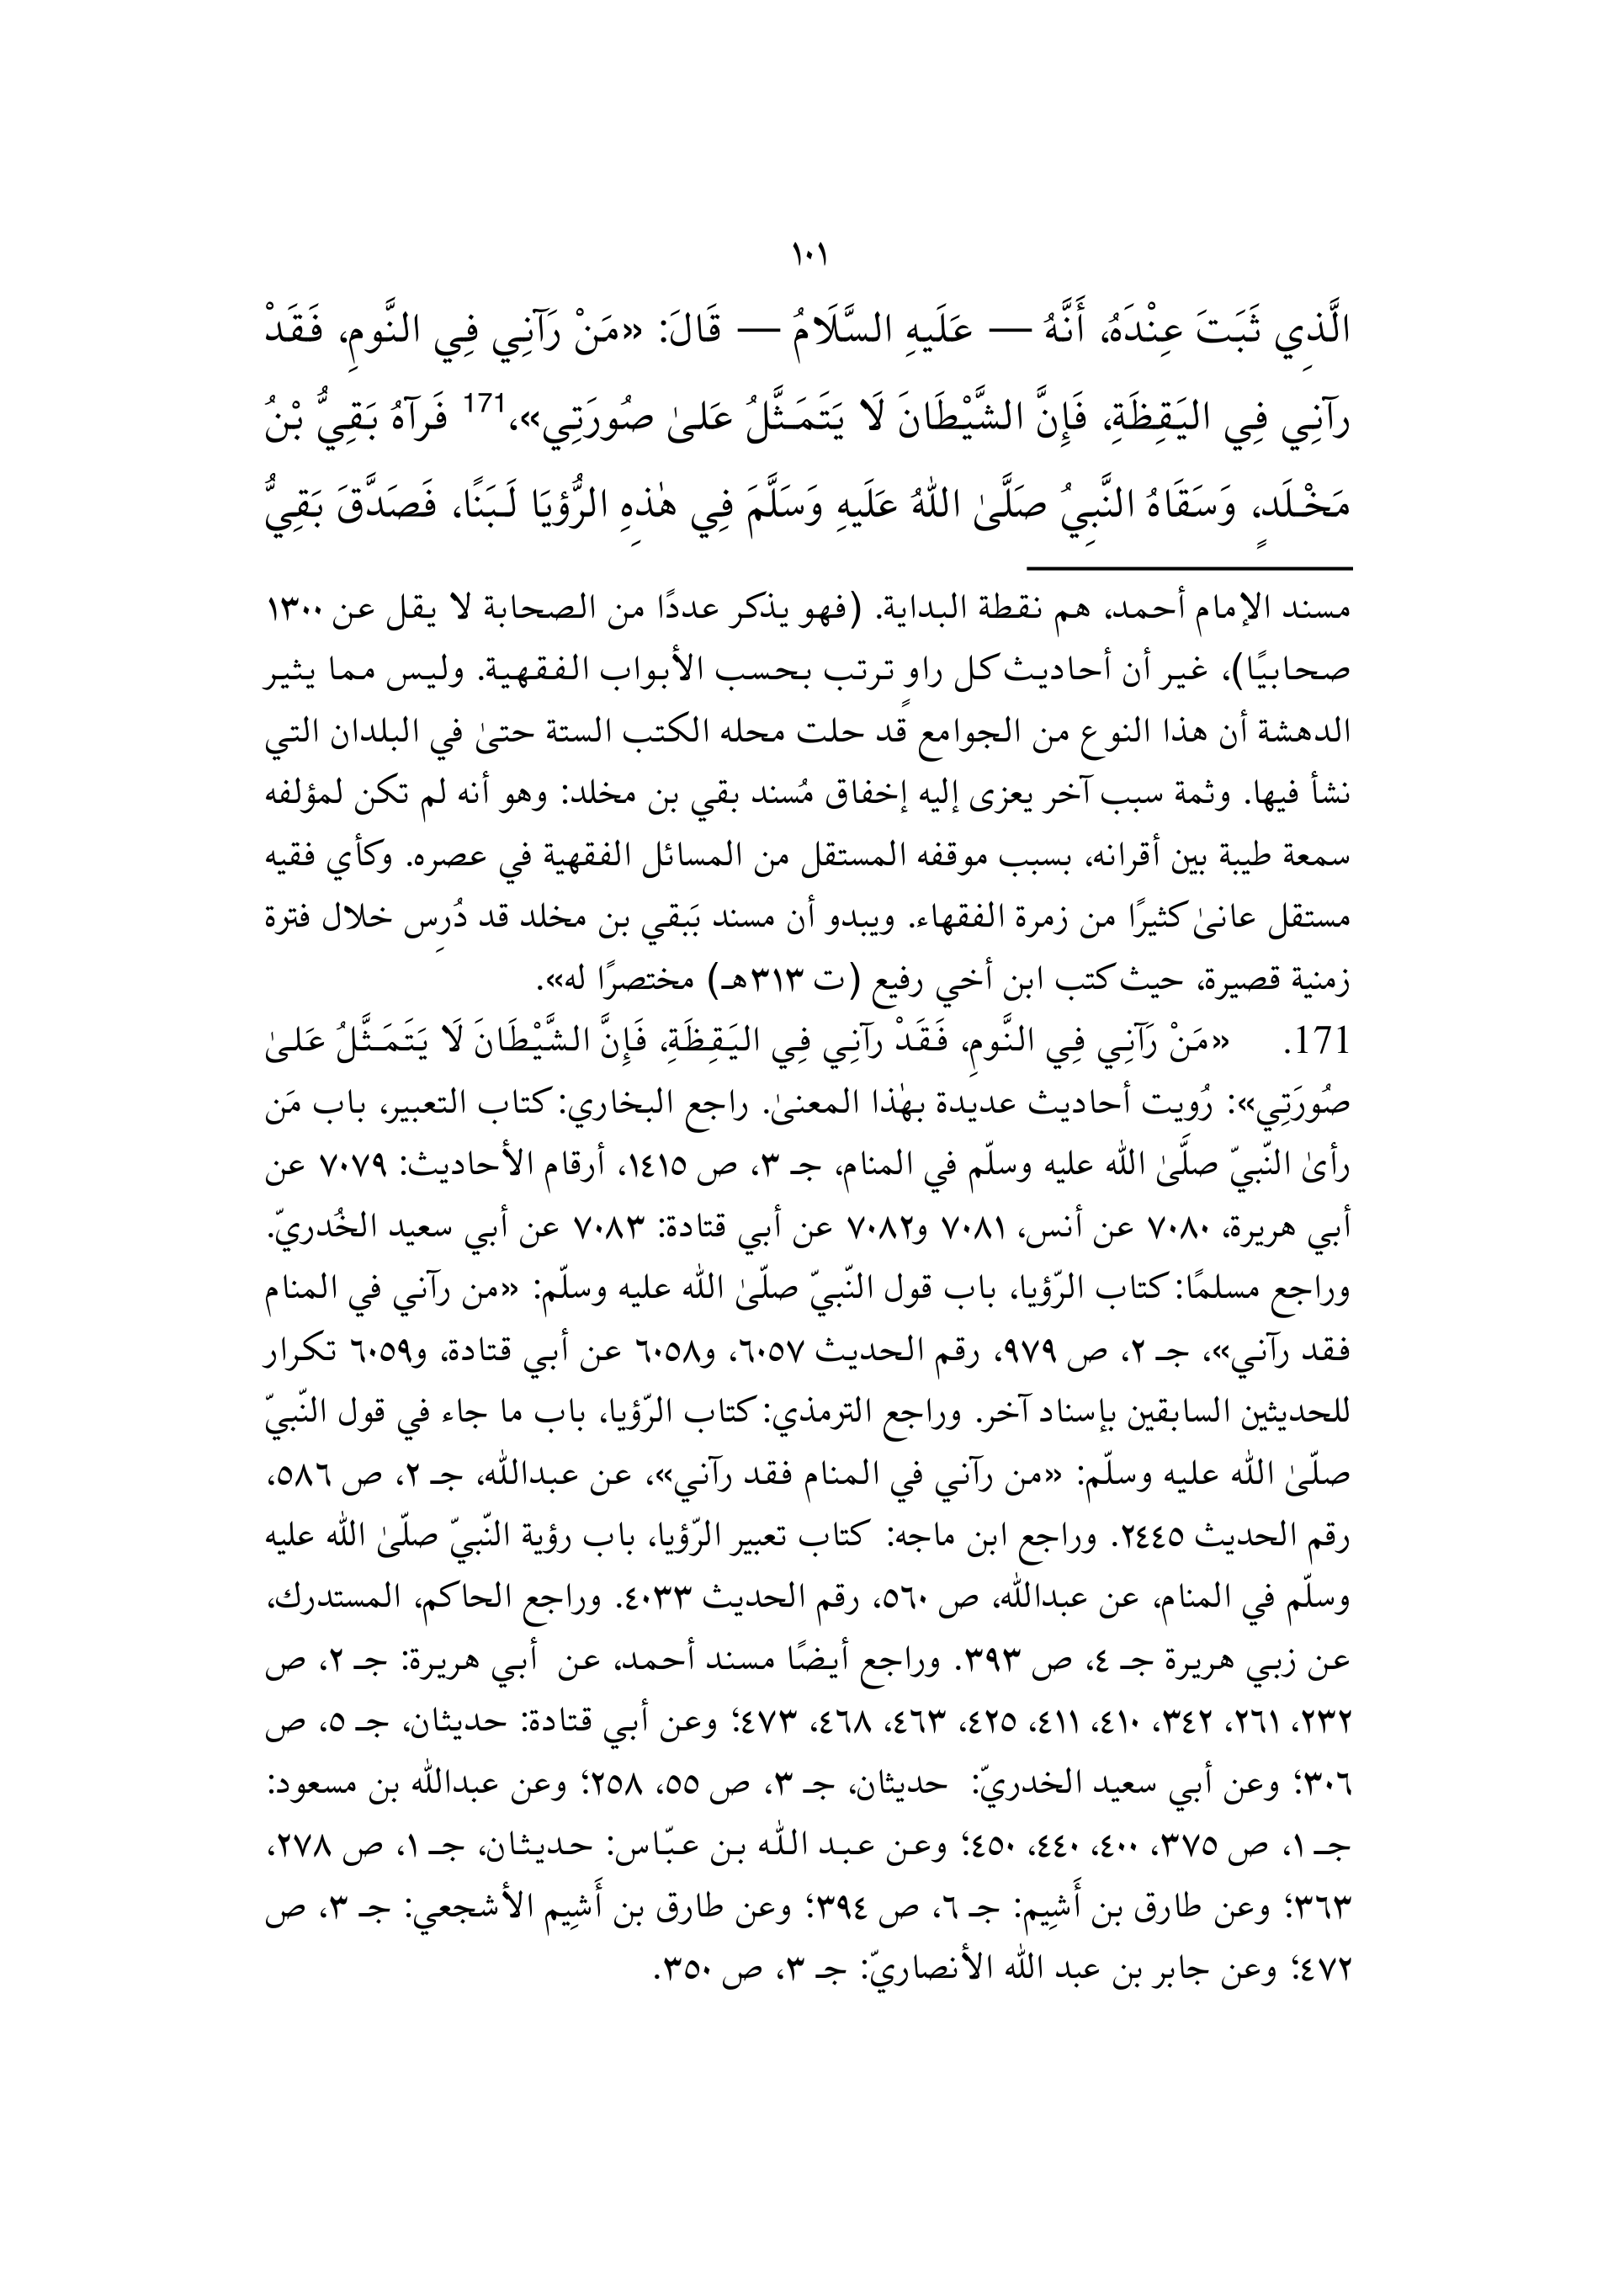

In [115]:
process(doc[100], "PNG")

In [57]:
process(doc[100], "XML")

In [35]:
process(doc[100], "WORDS")

[   (   357.4787902832031,
        86.697998046875,
        401.9999694824219,
        108.128662109375,
        'اﺍﻟ\ue821يﻱِﹺﺬﱠﺛ\ue821َﹶﺒ\ue821',
        0,
        0,
        0),
    (   331.1630859375,
        86.697998046875,
        367.3312072753906,
        108.128662109375,
        '\ue825ﺖ\ue825ﻋ\ue821\ue864ﻨ\ue821',
        0,
        1,
        0),
    (   251.9837646484375,
        86.697998046875,
        341.0149230957031,
        108.128662109375,
        '\ue815اﺍ،\ue8e9هﻩَﹶﺪْﹾﻧ\ue821\ue8e9ﻪﱠ―ﻋ\ue821\ue8e8ﻠ\ue821َﹶﻴ\ue821اﺍ',
        0,
        2,
        0),
    (   250.98019409179688,
        86.697998046875,
        273.4417419433594,
        108.128662109375,
        '\ue864ﻪﺴﻟ',
        0,
        2,
        1),
    (   249.83580017089844,
        86.697998046875,
        251.20982360839844,
        108.128662109375,
        '\ue821',
        0,
        3,
        0),
    (   258.01708984375,
        86.697998046875,
        259.39111328125,
        108.1286621093

In [33]:
process(doc[100], "BLOCKS")

[   (   65.0,
        86.697998046875,
        401.9999694824219,
        108.128662109375,
        'اﺍﻟ\ue821يﻱِﹺﺬﱠﺛ\ue821َﹶﺒ\ue821\n'
        '\ue825ﺖ\ue825ﻋ\ue821\ue864ﻨ\ue821\n'
        '\ue815اﺍ،\ue8e9هﻩَﹶﺪْﹾﻧ\ue821\ue8e9ﻪﱠ―ﻋ\ue821\ue8e8ﻠ\ue821َﹶﻴ\ue821اﺍ '
        '\ue864ﻪﺴﻟ\n'
        '\ue821 \ue821\n'
        '\ue826مﻡ\ue807َﹶ\ue80e\ue830\n'
        '―ﻗ\ue821\n'
        '» :\ue825لﻝﺎَﹶﻣ\ue821آﺁ\ue825رﺭ '
        '\ue828ﻦ\ue8e8ﻧ\ue821ﻲ\ue864ﻓ\ue821اﺍﻲ\ue864ﻨﻟ\ue821 \ue821\n'
        '،\ue8dfمﻡﻮﱠﻓ\ue821َﹶﻘ\ue821ْﹾﺪَﹶ\n',
        0,
        0),
    (   65.0,
        112.697998046875,
        402.0,
        134.128662109375,
        'آﺁرﺭﻧ\ue821ﻲ\ue864ﻓ\ue821اﺍﻲ\ue864ﻴﻟ\ue821 '
        '\ue821\ue825ﻘ\ue821\ue864ﻈ\ue821،\ue864ﺔَﹶﻓ\ue821اﺍﱠنﻥ\ue845ﺎَﹶﺸﻟ\n'
        '\ue821 \ue821ﱠﻴ\ue821\ue828ﻄ\ue821\n'
        '\ue806َﹶ\ue80a '
        'َﹶنﻥﺎَﹶﻳ\ue821\ue8e8ﺘ\ue821َﹶﻤ\ue821ـ\ue825ﺜ\ue821\ue826ﻞﱠﻋ\ue821\ue8e8ﻠ\ue821ﲐﺻ\n'
        '\ue821\ue825رﺭﻮ\ue826ﺗ\ue821\n'
        '،«ﻲ\ue864\n'
  

In [38]:
process(doc[100], "DICT")

[   {   'bbox': (   357.4787902832031,
                    86.697998046875,
                    401.9999694824219,
                    108.128662109375),
        'dir': (1.0, 0.0),
        'spans': [   {   'bbox': (   357.4787902832031,
                                     86.697998046875,
                                     401.9999694824219,
                                     108.128662109375),
                         'color': 0,
                         'flags': 4,
                         'font': 'XWZar',
                         'origin': (398.8486022949219, 102.215576171875),
                         'size': 14.0,
                         'text': 'اﺍﻟ\ue821يﻱِﹺﺬﱠﺛ\ue821َﹶﺒ\ue821'}],
        'wmode': 0},
    {   'bbox': (   331.1630859375,
                    86.697998046875,
                    367.3312072753906,
                    108.128662109375),
        'dir': (1.0, 0.0),
        'spans': [   {   'bbox': (   331.1630859375,
                                     86.697998

In [39]:
process(doc[100], "HTML")

WITH PRIVATE CHARS
<div id="page0" style="position:relative;width:482pt;height:680pt;background-color:white">
<p style="position:absolute;white-space:pre;margin:0;padding:0;top:86pt;left:366pt"><span style="font-family:XWZar,serif;font-size:14pt">&#x627;&#xfe8d;&#xfedf;&#xe821;&#x64a;&#xfef1;&#x650;&#xfe7a;&#xfeac;&#xfc60;&#xfe9b;&#xe821;&#x64e;&#xfe76;&#xfe92;&#xe821;</span></p>
<p style="position:absolute;white-space:pre;margin:0;padding:0;top:86pt;left:339pt"><span style="font-family:XWZar,serif;font-size:14pt">&#xe825;&#xfe96;&#xe825;&#xfecb;&#xe821;&#xe864;&#xfee8;&#xe821;</span></p>
<p style="position:absolute;white-space:pre;margin:0;padding:0;top:86pt;left:250pt"><span style="font-family:XWZar,serif;font-size:14pt">&#xe815;&#x627;&#xfe8d;&#x60c;&#xe8e9;&#x647;&#xfee9;&#x64e;&#xfe76;&#xfeaa;&#x652;&#xfe7e;&#xfee7;&#xe821;&#xe8e9;&#xfeea;&#xfc60;</span><span style="font-family:LucidaGrande,serif;font-size:14pt">&#x2015;</span><span style="font-family:XWZar,serif;font-size:14pt">&